## Import packages

In [1]:
import xarray as xr
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import scipy.stats as sc
import metpy as mtp
import math
from scipy import integrate
import ERA5_functions as era_fncts
import pandas as pd

from matplotlib.pyplot import cm
import datetime as dt

import cartopy.crs as ccrs
from numpy.random import default_rng

%load_ext autoreload
%autoreload 2

### Constants

In [2]:
a=6371220 #radius of earth in m
L=2.5E6 #Latent heat in atmosphere
L_ice=3.34e5 #Latent heat of fusion
g=9.81 #Acceleration from gravity
conv_pw=1e15 #Conversion from watts to PW
cp=1007          
    

### Dims

In [51]:
lats = np.linspace(90, -90, 361)
lons = np.linspace(0, 359.5, 720)
levels = [1, 2, 3, 5, 7, 10, 20, 30, 50, 70, 100, 125, 150, 175, 200, 225, 250, 300, 350,
            400, 450, 500, 550, 600, 650, 700, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000]
geometry = 2 * np.pi * np.cos(np.deg2rad(np.asarray(lats))) * a / g

### Load instantaneous AHT calcs

In [4]:
aht_ds = xr.open_dataset('aht_time_series/era5_aht_time_series.nc')

### Load local AHT calcs

In [33]:
local_ds = xr.open_dataset('aht_time_series/era5_aht_time_series_40deg.nc')

### Count exceedance of some large threshold

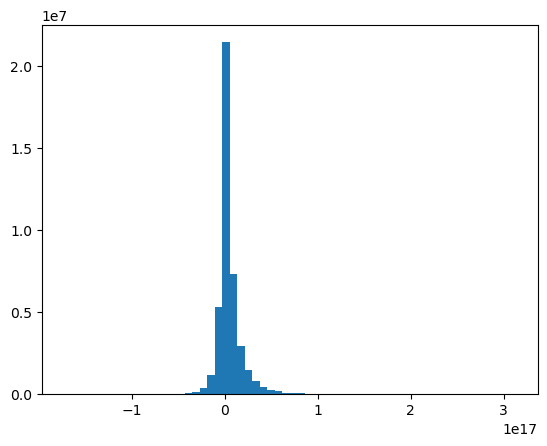

In [34]:
plt.hist(local_ds.eddy_aht.values.flatten(), bins=60)

plt.show()

In [36]:
thresh = 20e15

extreme_counts = (local_ds.eddy_aht >= thresh).sum()

print(extreme_counts.values)

print(np.size(local_ds.eddy_aht.values))

print('% of total data included in threshold is: ')
print(100 * extreme_counts.values / np.size(local_ds.eddy_aht.values))
#((da >= trange[0]) & (da <= trange[1])).sum(axis=0)

3726185
42076800
% of total data included in threshold is: 
8.85567581184881


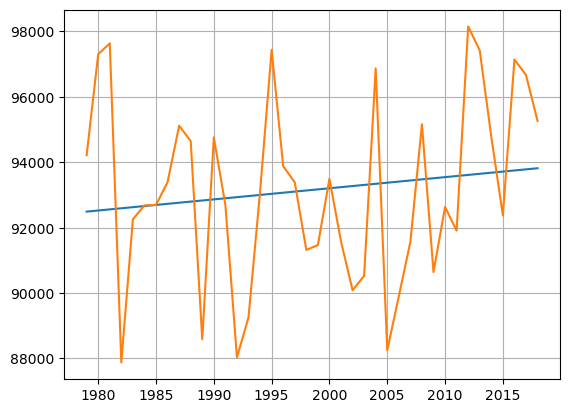

In [37]:
year_grouped = local_ds.eddy_aht.groupby('time.year')

years = np.arange(1979, 2019, 1)

extremes = np.zeros(len(years))

for idx, year in enumerate(years):
    extremes[idx] = (year_grouped[year] >= thresh).sum()

m, b = np.polyfit(years, extremes, 1)

plt.plot(years, m*years + b)

plt.plot(years, extremes)
plt.grid()
plt.show()

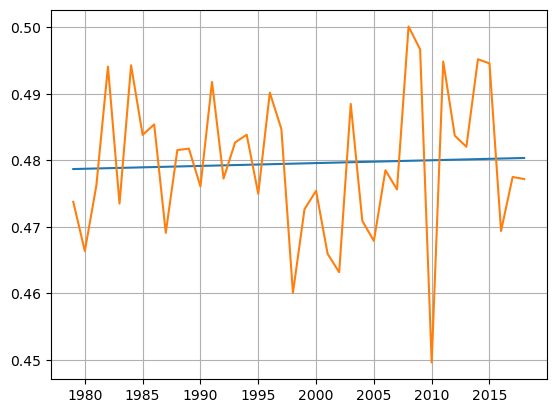

In [38]:
year_grouped = local_ds.eddy_aht.groupby('time.year')

percentile = 0.95

years = np.arange(1979, 2019, 1)

ratios = np.zeros(len(years))

for idx, year in enumerate(years):
    year_sorted = np.sort(year_grouped[year].values.flatten())
    top_x_perc = year_sorted[int(percentile * len(year_sorted)):]
    
    ratios[idx] = np.sum(top_x_perc) / np.sum(year_sorted)

m, b = np.polyfit(years, ratios, 1)

plt.plot(years, m*years + b)

plt.plot(years, ratios)
plt.grid()
plt.show()

In [20]:

year_sorted = aht_ds_70n.eddy_aht.values.flatten()
top_x_perc = year_sorted[int(percentile * len(year_sorted)):]
ratio = np.sum(top_x_perc) / np.sum(year_sorted)

print(ratio)

0.011825852032051842


### Look at zonal-mean changes

In [77]:
year_grouped = aht_ds.eddy_aht.groupby('time.year')


percentile = 0.95

years = np.arange(1979, 2019, 1)

ratios = np.zeros((len(lats), len(years)))

for i, lat in enumerate(lats):
    for j, year in enumerate(years):
        year_sorted = np.sort(year_grouped[year][:,i].values.flatten())
        top_x_perc = year_sorted[int(percentile * len(year_sorted)):]

        ratios[i, j] = np.sum(top_x_perc) / np.sum(year_sorted)

#m, b = np.polyfit(years, ratios, 1)
#plt.plot(years, m*years + b)
#plt.plot(years, ratios)
#plt.grid()

<ipython-input-77-305b0028c440>:15: RuntimeWarning: invalid value encountered in double_scalars
  ratios[i, j] = np.sum(top_x_perc) / np.sum(year_sorted)


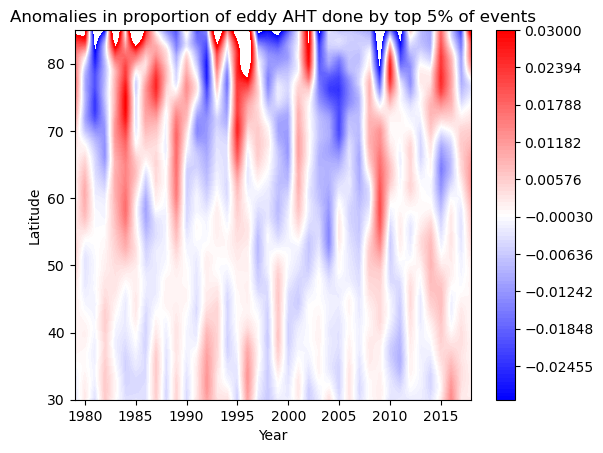

In [80]:
plt.contourf(years, lats, (ratios - np.mean(ratios, axis=1)[:,None]), levels=np.linspace(-.03, .03, 100), cmap='bwr')
#plt.contourf(years, lats, (ratios), levels=np.linspace(0, .3, 100), cmap='bwr')

plt.colorbar()

plt.ylim([30, 85])

plt.xlabel('Year')
plt.ylabel('Latitude')

plt.title('Anomalies in proportion of eddy AHT done by top 5% of events')
#plt.savefig('figures/3_15_22_meeting/eddy_aht_top_5_perc_zonal_means_by_year_anoms')

plt.show()

### Now look at multiple lats of local AHT

In [82]:
local_ds_40 = xr.open_dataset('aht_time_series/era5_aht_time_series_40deg.nc')
local_ds_60 = xr.open_dataset('aht_time_series/era5_aht_time_series_60deg.nc')
local_ds_70 = xr.open_dataset('aht_time_series/era5_aht_time_series_70deg.nc')

In [92]:
full_local_ds = xr.concat([local_ds_40, local_ds_60, local_ds_70], pd.Index([40, 60, 70], name='latitude'))

In [93]:
full_local_ds

<xarray.Dataset>
Dimensions:              (latitude: 3, time: 58440, longitude: 720)
Coordinates:
  * time                 (time) datetime64[ns] 1979-01-01 ... 2018-12-31T18:0...
  * longitude            (longitude) float64 0.0 0.5 1.0 ... 358.5 359.0 359.5
  * latitude             (latitude) int64 40 60 70
Data variables:
    eddy_aht             (latitude, time, longitude) float64 -1.009e+16 ... -...
    mmc_aht              (latitude, time) float64 -1.799e+15 ... 3.756e+14
    eddy_aht_no_seasons  (latitude, time, longitude) float64 -8.203e+15 ... -...
    mmc_aht_no_seasons   (latitude, time) float64 -1.423e+15 ... 7.08e+14
Attributes:
    description:  AHT data at 40deg

In [102]:
year_grouped = full_local_ds.eddy_aht.groupby('time.year')

#print(np.shape(year_grouped[1979]))
percentile = 0.95

years = np.arange(1979, 2019, 1)
local_lats = [40, 60, 70]


ratios_local = np.zeros((len(local_lats), len(years)))

for i, lat in enumerate(local_lats):
    for j, year in enumerate(years):
        year_sorted = np.sort(year_grouped[year][i,:,:].values.flatten())
        top_x_perc = year_sorted[int(percentile * len(year_sorted)):]

        ratios_local[i, j] = np.sum(top_x_perc) / np.sum(year_sorted)

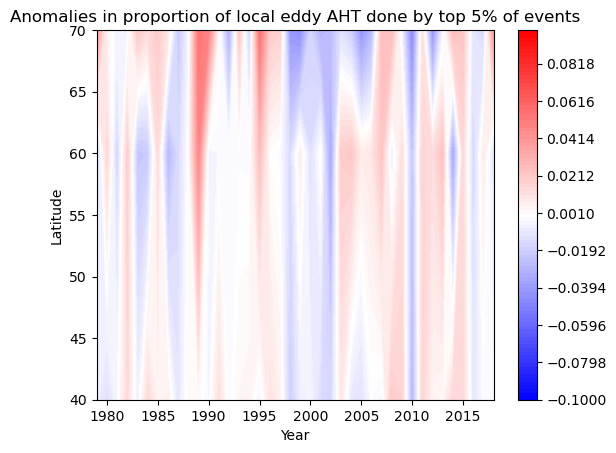

In [108]:
plt.contourf(years, local_lats, (ratios_local - np.mean(ratios_local, axis=1)[:,None]), levels=np.linspace(-.1, .1, 100), cmap='bwr')
#plt.contourf(years, local_lats, (ratios_local), levels=np.linspace(0, 0.7, 100), cmap='bwr')

plt.colorbar()

#plt.ylim([30, 85])

plt.xlabel('Year')
plt.ylabel('Latitude')

plt.title('Anomalies in proportion of local eddy AHT done by top 5% of events')
#plt.savefig('figures/3_15_22_meeting/eddy_aht_top_5_perc_local_eddy_by_year_anoms')

plt.show()